# Assignment 1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import explained_variance_score
from sklearn import metrics
import statsmodels.api as sm
import itertools
import time
import networkx as nx
import random
import lightgbm as lgb
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from sklearn.preprocessing import StandardScaler
import sklearn.utils
import seaborn as sns
from sklearn.model_selection import cross_val_score

def shortestDistance(graph, n1, n2):
    try:
        return 1 / nx.shortest_path_length(graph, n1, n2)
    except:
        return 0


def commonNeighbours(graph, n1, n2):
    try:
        return len(list(nx.common_neighbors(graph, n1, n2)))
    except:
        return 0


def jaccard(graph, n1, n2):
    try:
        return list(nx.jaccard_coefficient(graph, [(n1, n2)]))[0][2]
    except:
        return 0


def adamicAdar(graph, n1, n2):
    try:
        return list(nx.adamic_adar_index(graph, [(n1, n2)]))[0][2]
    except:
        return 0


def preferentialAttachment(graph, n1, n2):
    try:
        return list(nx.preferential_attachment(graph, [(n1, n2)]))[0][2]
    except:
        return 0


def resourceAllocation(graph, n1, n2):
    try:
        return list(nx.resource_allocation_index(graph, [(n1, n2)]))[0][2]
    except:
        return 0


def localPath(graph, n1, n2):
    try:
        paths = list(nx.all_simple_paths(graph, source=n1, target=n2, cutoff=3))
        A2 = 0.0
        A3 = 0.0
        A1 = 0.0
        for path in paths:
            if len(path) == 3:
                A2 = A2 + 1.0
            elif len(path) == 4:
                A3 = A3 + 1.0
            elif len(path) == 2:
                A1 = A1 + 1.0

        return A1 + 0.1 * A2 + 0.01 * A3
    except:
        return 0

def Bet(graph, n1, n2):
    try:
        b1 = 1/graph.nodes[n1]['betweenness']
        b2 = 1/graph.nodes[n2]['betweenness']
    except:
        b1 = 0
        b2 = 0
    return max(b1, b2)

def Eig(graph, n1, n2):
    try:
        e1 = 1/graph.nodes[n1]['eigenvector']
        e2 = 1/graph.nodes[n2]['eigenvector']
    except:
        e1 = 0
        e2 = 0
    return max(e1, e2)

def com_ra(graph, n1, n2):
    try:
        return list(nx.ra_index_soundarajan_hopcroft(trainGraph, [(n1, n2)]))[0][2]
    except:
        return 0

def component(graph, n1, n2):
    try:
        e1 = graph.nodes[n1]['component']
        e2 = graph.nodes[n2]['component']
    except:
        e1 = 0
        e2 = 0
    return max(e1, e2)
    
    
def addFeaturesToDataframe(graph, data):
    #data['CommonNeighbours'] = data.apply(lambda l: commonNeighbours(graph, l.Source, l.Sink), axis=1)
    #print('Added "CommonNeighbours" column')
    #data['Jaccard'] = data.apply(lambda l: jaccard(graph, l.Source, l.Sink), axis=1)
    #print('Added "Jaccard" column')
    data['AdamicAdar'] = data.apply(lambda l: adamicAdar(graph, l.Source, l.Sink), axis=1)
    print('Added "AdamicAdar" column')
#     data['PreferentialAttachment'] = data.apply(lambda l: preferentialAttachment(graph, l.Source, l.Sink), axis=1)
#     print('Added "PreferentialAttachment" column')
#     data['ResourceAllocation'] = data.apply(lambda l: resourceAllocation(graph, l.Source, l.Sink), axis=1)
#     print('Added "ResourceAllocation" column')
#     data['Dist'] = data.apply(lambda l: shortestDistance(graph, l.Source, l.Sink),
#                               axis=1)  ## can't just leave as highest number cause will be detrimental when normalising
#     print('Added "Dist" column')

    # newly-added
    data['CCN'] = data.apply(lambda l: com_ra(graph, l.Source, l.Sink), axis=1)
    print('Added "CCN" column')
    data['Betweeness'] = data.apply(lambda l: Bet(graph, l.Source, l.Sink), axis=1)
    print('Added "Betweeness" column')
    data['Eigenvector'] = data.apply(lambda l: Eig(graph, l.Source, l.Sink), axis=1)
    print('Added "Eigenvector" column')
    data['Component'] = data.apply(lambda l: component(graph, l.Source, l.Sink), axis=1)
    print('Added "Component" column')
    data['LP'] = data.apply(lambda l: localPath(graph, l.Source, l.Sink), axis=1)
    print('Added "LP" column')


def addmoreFeatures(g1, df3):
    # generate features
    df_tmp = df3.copy()
    CNs, SIs, JCs, HPIs, HDIs, PAs, RAs = [], [], [], [], [], [], []
    for idx, i in df_tmp.iterrows():
        n1 = int(i[0])
        n2 = int(i[1])
        CN, SI, JC, HPI, HDI, PA, RA = Pxy(g1, n1, n2)
        CNs.append(CN)
        SIs.append(SI)
        JCs.append(JC)
        HPIs.append(HPI)
        HDIs.append(HDI)
        PAs.append(PA)
        RAs.append(RA)

    df_tmp['CN'] = CNs
    df_tmp['SI'] = SIs
    df_tmp['JC'] = JCs
    df_tmp['HPI'] = HPIs
    df_tmp['HDI'] = HDIs
    df_tmp['PA'] = PAs
    df_tmp['RA'] = RAs
    return df_tmp

# network graph drawing
def createG1(txt):
    g1 = {}
    converted_txt = []
    tmp = []
    for link in txt:
        for subset in itertools.permutations(link, 2):
            tmp.append(subset[0])
            tmp.append(subset[1])
            converted_txt.append(subset)
    train1 = pd.DataFrame(converted_txt, columns=["srce", "dest"])
    freq = train1.groupby(["srce", "dest"]).size().values
    #train1['freq'] = freq
    txt_1 = sorted(set(converted_txt))
    df1 = pd.DataFrame(txt_1, columns=["srce", "dest"])
    df1['freq'] = freq
    df1['score'] = 1 - 0.99/freq
    for points, f in zip(txt_1, freq):
        g1[points[0]] = g1.setdefault(points[0], [])
        g1[points[0]].append((points[1], f))

    return g1, list(set(tmp)), df1


# path finding
def find_min(open_dict, sink):
    if sink in open_dict.keys():
        return [sink, open_dict[sink][0], open_dict[sink][1]]
    values = list(open_dict.values())
    values.sort(key=lambda x: x[1])
    min = values[0][0]
    for i in open_dict.keys():
        if open_dict[i][0] == min:
            return [i, open_dict[i][0], open_dict[i][1]]


def show_path(close_dict, path, sink):
    if (sink in close_dict.keys()):
        path.append(sink)
        path = show_path(close_dict, path, close_dict[sink][1])
    return path


def find_path(g1, srce, sink):
    path = []
    open_dict = {srce: [0, -1]}
    close_dict = {}
    while len(open_dict.keys()) != 0:
        min_key = find_min(open_dict, sink)
        close_dict[min_key[0]] = [min_key[1], min_key[2]]  # [score, parent node]
        if min_key[0] == sink:
            return show_path(close_dict, path, sink)[::-1]
        else:
            subnodes = []
            if min_key[0] not in g1.keys():
                open_dict.pop(min_key[0])
                continue
            for i in g1[min_key[0]]:
                subnodes.append([i[0], i[1], min_key[0]])  # [current, score, parent node]
            for node in subnodes:
                if node[0] in close_dict.keys():
                    continue
                if node[0] not in open_dict.keys():
                    open_dict[node[0]] = [node[1], node[2]]
                elif node[0] in open_dict.keys():
                    if open_dict[node[0]][0] > node[1]:
                        open_dict[node[0]][0] = node[1]
                        open_dict[node[0]][1] = node[2]
            open_dict.pop(min_key[0])
    return []


def cal_score(g1, path):
    s = 0
    for i in range(len(path) - 1):
        for j in g1[path[i]]:
            if j[0] == path[i + 1]:
                s += j[1]
    return s

#load test data
def loadTestData(filename):
    return pd.read_csv(filename)

#generating features
def fu(g1, u):
    return 1

def getNodeScore(g1, Nu):
    AA = 0
    RA = 0
    CCN = len(Nu)
    CRA = 0
    if len(Nu) == 0:
        return 0, 0, 0, 0
    for u in Nu:
        AA += 1/np.log(len(g1[u]))
        RA += 1/len(g1[u])
        CCN += fu(g1, u)
        CRA += fu(g1, u)/len(g1[u])
    return AA, RA, CCN, CRA

def Pxy(g1, x, y):
    try:
        Gx = g1[x]
        Gy = g1[y]
    except:
        return 0, 0, 0, 0, 0, 0, 0
    Nx = [i[0] for i in Gx]
    Ny = [i[0] for i in Gy]
    NxINy = list(set(Nx) & set(Ny))
    NxUNy = list(set(Nx + Ny))
    AA, RA, CCN, CRA = getNodeScore(g1, NxINy)
    cardNx = len(Nx)
    cardNy = len(Ny)
    PA = cardNx * cardNy
    JC = len(NxINy)/len(NxUNy)
    HPI = len(NxINy)/min(cardNx, cardNy)
    HDI = len(NxINy)/max(cardNx, cardNy)
    return len(NxINy), len(NxINy)/np.sqrt(cardNx*cardNy), JC, HPI, HDI, PA, RA

#load train data
def loadTrainData():
    filename = "train.txt"
    return [line.rstrip("\n") for line in open(filename)]

#create graph
def createUndirectedGraph(dataRow):
    g = nx.Graph()
    for row in dataRow:
        authorIds = row.split()
        for i, author in enumerate(authorIds):
            for coauthor in authorIds[i+1:]:
                if g.has_edge(author, coauthor):
                    pass
                else:
                    g.add_edge(author, coauthor)
    return g

#normalize result
def normalize(results):
    minf = min(results)
    maxf = max(results)
    new = []
    for i in results:
        newi = (i - minf)/(maxf - minf)
        new.append(newi)
    return new

#read train data
def readTxtFile(filename):
    return [line.rstrip("\n") for line in open(filename)]

# preprocess training data
def pre_row(trainRow):
    txt = [list(map(int, i.split())) for i in trainRow]
    trainGraph = createUndirectedGraph(trainRow)
    g1 = {}
    converted_txt = []
    tmp = []
    for link in txt:
        for subset in itertools.permutations(link, 2):
            tmp.append(subset[0])
            tmp.append(subset[1])
            converted_txt.append(subset)
    train1 = pd.DataFrame(converted_txt, columns=["Source", "Sink"])
    freq = train1.groupby(["Source", "Sink"]).size().values
    #train1['freq'] = freq
    txt_1 = sorted(set(converted_txt))
    df1 = pd.DataFrame(txt_1, columns=["Source", "Sink"])
    #df1['freq'] = freq
    df1['score'] = 1
    for points, f in zip(txt_1, freq):
        g1[points[0]] = g1.setdefault(points[0], [])
        g1[points[0]].append((points[1], f))
    V = list(set(tmp))
    return g1, V, df1, txt_1

#evaluation function mentioned in paper
def AUC(R, M):
    nume = 0
    deno = 0
    for i in R:
        deno += len(M)
        nume += sum(i > j for j in M)
        nume += 0.5*list(M).count(i)
    return nume/deno

def precision(R, M, thres):
    s1 = sum(i > thres for i in R)
    s2 = sum(j > thres for j in M)
    return (s1)/(s1+s2)

def localPath2(graph, n1, n2):
    try:
        paths = list(nx.all_simple_paths(graph, source=n1, target=n2, cutoff=3))
        A2 = 0.0
        A3 = 0.0
        A1 = 0.0
        for path in paths:
            if len(path) == 3:
                A2 = A2 + 1.0
            elif len(path) == 4:
                A3 = A3 + 1.0
            elif len(path) == 2:
                A1 = A1 + 1.0
        return A1, A2, A3
    except:
        return 0, 0, 0

#this function is used in K-fold, it take splitted data, train train dataset and holdout dev dataset
def rowtoauc(trainRow, devRow, trainGraph, lr):
    # Load and Preprocess data
    g1, V, df1, txt_1 = pre_row(trainRow)
    # generate psudo data based on missing link
    psuedo = []
    i = 0
    while len(psuedo) < len(txt_1):
        random.seed(i)
        nodes = random.sample(V, 2)
        n1, n2 = nodes[0], nodes[1]
        if trainGraph.has_edge(n1, n2):
            pass
        else:
            if [n1, n2, 0] not in psuedo:
                psuedo.append([n1, n2, 0])
        i += 1

    df2 = pd.DataFrame(psuedo, columns=["Source", "Sink", 'score'])
    df3 = df1.append(df2)

    addFeaturesToDataframe(trainGraph, df3)
    df3 = addmoreFeatures(g1, df3)

    # train_test_split
    features = ['AdamicAdar','LP']
    X_train = df3[features]
    y_train = df3['score']
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
    #sc = StandardScaler()
    #X_train = sc.fit_transform(X_train)
    # train model
    print("training start")

    lr.fit(X_train, y_train)
    p_set = [[i[0], i[1]] for i in psuedo]
    df_psuedo = pd.DataFrame(p_set, columns = ["Source", "Sink"])

    addFeaturesToDataframe(trainGraph, df_psuedo)
    df_psuedo= addmoreFeatures(g1, df_psuedo)
    X_psuedo = df_psuedo[features]
    #X_psuedo = sc.transform(X_psuedo)
    
    y_psuedo = lr.predict_proba(X_psuedo)
    y_psuedo = [i[1] for i in y_psuedo]
    g_dev, V_dev, df_dev, txt_dev = pre_row(devRow)

    addFeaturesToDataframe(trainGraph, df_dev)
    df_dev = addmoreFeatures(g1, df_dev)
    X_dev = df_dev[features]
    #X_dev = sc.transform(X_dev)
    
    y_dev = lr.predict_proba(X_dev)
    y_dev = [i[1] for i in y_dev]
    n_dev = random.sample(list(y_dev), 1000)
    n_psuedo = random.sample(list(y_psuedo), 1000)
    auc = AUC(n_dev, n_psuedo)
    prec = precision(y_dev, y_psuedo, 0.5)
    print(auc, prec)
    return auc, prec, lr

def loadTrainDataAsUndirectedGraph():
    filename = "train.txt"
    rows = [line.rstrip("\n") for line in open(filename)]
    g = nx.Graph()
    for row in rows:
        authorIds = row.split()
        for i, author in enumerate(authorIds):
            for coauthor in authorIds[i+1:]:
                if g.has_edge(author, coauthor):
                    g[author][coauthor]['frequency'] += 1
                else:
                    g.add_edge(author, coauthor, frequency=1)
    return g

def createBalancedTrainingData(graph, testDF):
    trueInstances = [[n1, n2, 1] for (n1, n2) in graph.edges if graph[n1][n2]['frequency'] > 1]
#     trueInstances = [[n1, n2, 1] for (n1, n2) in graph.edges]  
    sourceSink = testDF["Source-Sink"].tolist()
    adj_G = nx.to_numpy_matrix(graph, nodelist = graph.nodes)
    # get unconnected node-pairs
    f1 = []
    f2 = []

    # traverse adjacency matrix
    l = int(0.5 * len(trueInstances))
    while len(f1) < l or len(f2) < l:
        random.seed() # Removed seed
        i = random.sample(range(adj_G.shape[0]), 1)[0]
        j = random.sample(range(adj_G.shape[1]), 1)[0]
        try:
            # If shortest path > 4 then score goes down to 0.77
            if 4 < nx.shortest_path_length(graph, str(i), str(j)):
                if len(f2) < l and (i,j) not in sourceSink:
                    #print(i, j)
                    f2.append([str(i), str(j), 0])
        except:
            if len(f1) < l and (i,j) not in sourceSink:
                f1.append([str(i), str(j), 0])
        
    print('len(f1):',len(f1))
    print('len(f2):',len(f2))
    print('len(trueInstances):',len(trueInstances))
    
    data = sklearn.utils.shuffle(f1+f2+trueInstances)
    return pd.DataFrame(data,columns=['Source','Sink','Label'])

def randomlyClassify(frequency):
    maxFreq = 5
    minFreq = 0
    prob = (maxFreq - frequency) / (maxFreq - minFreq)
    prob = prob if prob < 1 else 1
    prob = prob if prob > 0 else 0
    return np.random.choice([0, 1], p=[prob, 1- prob])

def createInbalanced(graph, testDF):
    trueInstances = [[n1, n2, 1] for (n1, n2) in graph.edges if graph[n1][n2]['frequency'] > 1]
#     trueInstances = [[n1, n2, 1] for (n1, n2) in graph.edges]  
    sourceSink = testDF["Source-Sink"].tolist()
    adj_G = nx.to_numpy_matrix(graph, nodelist = graph.nodes)
    # get unconnected node-pairs
    f1 = []
    f2 = []

    # traverse adjacency matrix
    l = int(0.5 * len(trueInstances))
    while len(f1) < l or len(f2) < l:
        random.seed() # Removed seed
        i = random.sample(range(adj_G.shape[0]), 1)[0]
        j = random.sample(range(adj_G.shape[1]), 1)[0]
        try:
            # If shortest path > 4 then score goes down to 0.77
            if 2 < nx.shortest_path_length(graph, str(i), str(j)):
                if len(f2) < l and (i,j) not in sourceSink:
                    #print(i, j)
                    f2.append([str(i), str(j), 0])
        except:
            if len(f1) < l and (i,j) not in sourceSink:
                f1.append([str(i), str(j), 0])
        
    print('len(f1):',len(f1))
    print('len(f2):',len(f2))
    print('len(trueInstances):',len(trueInstances))
    
    data = sklearn.utils.shuffle(f1+f2+trueInstances)
    return pd.DataFrame(data,columns=['Source','Sink','Label'])
    

In [2]:
trainGraph = loadTrainDataAsUndirectedGraph()

In [3]:
nx.density(trainGraph)

0.0022607373392858378

In [4]:
nx.transitivity(trainGraph)

0.3472436599242601

In [5]:
components = list(nx.connected_components(trainGraph))

D:\anaconda\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


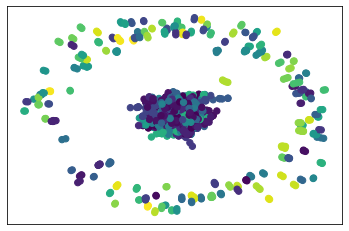

In [6]:
import community as community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx

partition = community_louvain.best_partition(trainGraph)
# draw the graph
pos = nx.spring_layout(trainGraph)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(trainGraph, pos, partition.keys(), node_size=40,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(trainGraph, pos, alpha=0.5)
plt.show()

In [ ]:
betweenness_dict = nx.betweenness_centrality(trainGraph)
eigenvector_dict = nx.eigenvector_centrality(trainGraph)

In [ ]:
nodes = list(trainGraph.nodes) 
component_dict = {}
for j in nodes:
    for idx, i in enumerate(components):
        tmp = list(i)
        #print(tmp)
        if str(j) in tmp:
            component_dict[j] = np.log(len(i))

In [ ]:
nx.set_node_attributes(trainGraph, component_dict, 'component')
nx.set_node_attributes(trainGraph, betweenness_dict, 'betweenness')
nx.set_node_attributes(trainGraph, eigenvector_dict, 'eigenvector')
nx.set_node_attributes(trainGraph, partition, 'community')
#print(betweenness_dict)
#print(eigenvector_dict)

In [ ]:
preds = nx.ra_index_soundarajan_hopcroft(trainGraph, [('0', '1236')])
print(list(preds)[0][2])

In [ ]:
testDF = pd.read_csv('test-public.csv', converters = {'Source': str, 'Sink': str})
testDF['Source-Sink'] = list(zip(testDF['Source'], testDF['Sink']))
trainDF = createBalancedTrainingData(trainGraph, testDF)

In [ ]:
addFeaturesToDataframe(trainGraph, trainDF)
addFeaturesToDataframe(trainGraph, testDF)

#trainDF = addmoreFeatures(g1, trainDF)
#testDF = addmoreFeatures(g1,testDF)

In [ ]:

features = ['LP','Betweeness', 'Eigenvector', 'AdamicAdar']
#features = ['LP','AdamicAdar']
X_train1 = trainDF[features]
y_train = trainDF['Label']
X_test1 = testDF[features]
testIds = testDF['Id']
sc = StandardScaler()
X_train = sc.fit_transform(X_train1)
X_test = sc.transform(X_test1)
lr = LogisticRegression(class_weight="balanced")
print(cross_val_score(lr, X_train, y_train, scoring='roc_auc', cv=10))
lr.fit(X_train, y_train)
predictions = lr.predict_proba(X_test)

In [ ]:
X_pred = list(trainDF['Label'])
y_pred = list(predictions[:, 1])
sns.distplot(X_pred)

In [ ]:
sns.distplot(y_pred)

In [ ]:
final_result = pd.DataFrame(data={'Id': testIds, 'Predicted': predictions[:,1]})
final_result.to_csv('results/LogisticRegression.csv', index=False)

In [ ]:
X_test[:30]

In [ ]:
X_train

In [ ]:
train1 = loadTrainData()
random.shuffle(train1)
trainRow = train1
g1, V, df1, txt_1 = pre_row(trainRow)
g1[14]

In [ ]:
# Load data
test = pd.read_csv("test-public.csv")
train1 = loadTrainData()
trainGraph  = createUndirectedGraph(train1)
random.shuffle(train1)
auc_l = []
prec_l = []
model_l = []
kf = KFold(n_splits=5,shuffle=False)
traindf = np.array(train1)
lr = LogisticRegression(class_weight="balanced")
for train_index, dev_index in kf.split(train1):
    X_train, X_dev = traindf[train_index], traindf[dev_index]
    auc, prec, lr = rowtoauc(X_train, X_dev, trainGraph, lr)
    auc_l.append(auc)
    prec_l.append(prec)
    model_l.append(lr)

In [ ]:
print(sum(auc_l)/len(auc_l), sum(prec_l)/len(prec_l))
print(max(auc_l), max(prec_l))